In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches

import os
os.chdir("/Users/deweywang/Desktop/GitHub/HEVisum/")

# Training data preparation 

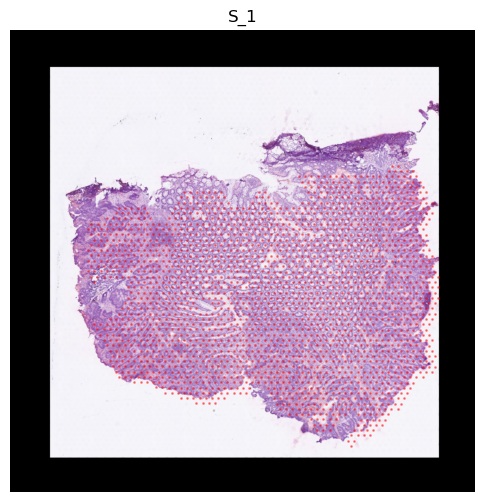

In [2]:
with h5py.File("./dataset/filtered&masked_dataset.h5", "r") as h5file:
    train_images = h5file["images/Train"]
    train_spots = h5file["spots/Train"]
    
    sample = 'S_1'
    image = np.array(train_images[sample])
    spots = np.array(train_spots[sample])
    x, y = spots["x"], spots["y"]
    
    plt.figure(figsize=(6,6))
    plt.imshow(image, aspect="auto")
    plt.scatter(x, y, color="red", s=1, alpha=0.4)
    plt.axis('off')
    plt.title(sample)
    plt.show()

In [3]:

# Load and display (x,y) spot locations and cell type annotation table for Train slides
with h5py.File("./dataset/version-7/no_gu_clip4_processed_train_spots.h5", "r") as f:
    train_spots = f["spots/log2_Train"]
    
    # Dictionary to store DataFrames for each slide
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        # Load dataset as NumPy structured array
        spot_array = np.array(train_spots[slide_name])
        
        # Convert to DataFrame
        df = pd.DataFrame(spot_array)
        
        # Store in dictionary
        train_spot_tables[slide_name] = df
        print(slide_name)

# Example: Display the spots table for slide 'S_1'
train_spot_tables['S_1']

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = './dataset/version-7/no_gu_clip4_processed_train_spots.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

## log 2

In [5]:
import h5py
import numpy as np
import pandas as pd
from scipy.stats import rankdata

# -----------------------------------------------------
# Step 1: 讀取 HDF5 中 Train slide 的 spot 資料，並以 slide 名稱建立 DataFrame 字典
# -----------------------------------------------------
with h5py.File("dataset/spot-rank/version-1/directly_rank_train_spots.h5", "r") as f:
    train_spots = f["spots/Train"]
    
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        spot_array = np.array(train_spots[slide_name])
        df = pd.DataFrame(spot_array)
        df["slide_name"] = slide_name
        train_spot_tables[slide_name] = df
        print(f"✅ 已讀取 slide: {slide_name}")

# -----------------------------------------------------
# Step 2: 合併所有 slide 的資料
# -----------------------------------------------------
all_train_spots_df = pd.concat(train_spot_tables.values(), ignore_index=True)

if "slide_name" not in all_train_spots_df.columns:
    all_train_spots_df["slide_name"] = all_train_spots_df.index.map(lambda i: "unknown")

# -----------------------------------------------------
# Step 3: 對每一個 spot 的 cell abundances 進行排名
# -----------------------------------------------------
cell_type_cols = [col for col in all_train_spots_df.columns if col.startswith("rank_C")]

# 建立一個新的 DataFrame 儲存排名資訊
ranked_df = all_train_spots_df.copy()

# 對每一行做排名（axis=1）
ranked_values = all_train_spots_df[cell_type_cols].apply(
    lambda row: rankdata(row.values, method="ordinal"), axis=1, result_type='expand'
)

# 用原本欄位名稱替代
ranked_values.columns = [f"{col}" for col in cell_type_cols]

# 合併到 ranked_df
ranked_df = pd.concat([ranked_df.drop(columns=cell_type_cols), ranked_values], axis=1)

# -----------------------------------------------------
# Step 4: 顯示排名後的統計描述
# -----------------------------------------------------
print("\n🏁 Ranking done! 每個 cell type 的排名描述:")
print(ranked_df[[col for col in ranked_df.columns if col.startswith("rank_")]].describe())

# ranked_df 現在就可以用來做 Spearman-based 模型訓練 🎯


✅ 已讀取 slide: S_1
✅ 已讀取 slide: S_2
✅ 已讀取 slide: S_3
✅ 已讀取 slide: S_4
✅ 已讀取 slide: S_5
✅ 已讀取 slide: S_6

🏁 Ranking done! 每個 cell type 的排名描述:
           rank_C1      rank_C2      rank_C3      rank_C4      rank_C5  \
count  8181.000000  8181.000000  8181.000000  8181.000000  8181.000000   
mean     26.003789    27.397751    26.416331    17.287740    25.749175   
std       7.823112     3.593320     5.958023    12.164865    11.088218   
min       7.000000    15.000000    10.000000     1.000000     1.000000   
25%      19.000000    24.000000    21.000000     6.000000    18.000000   
50%      27.000000    28.000000    26.000000    14.000000    32.000000   
75%      34.000000    31.000000    33.000000    32.000000    34.000000   
max      35.000000    35.000000    35.000000    35.000000    35.000000   

           rank_C6      rank_C7      rank_C8      rank_C9     rank_C10  ...  \
count  8181.000000  8181.000000  8181.000000  8181.000000  8181.000000  ...   
mean     15.366581    20.154504    1

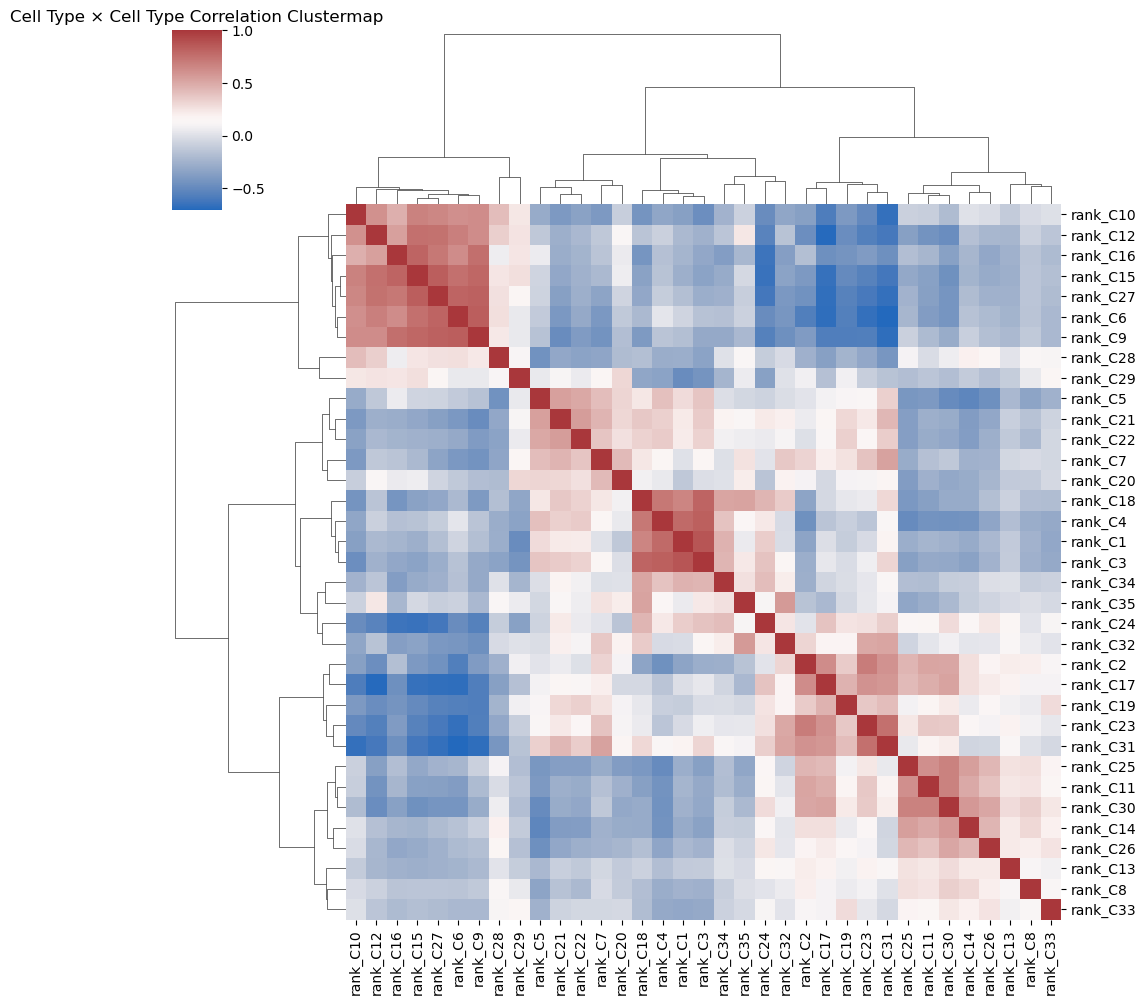

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# 原始資料：filtered_df[zscore_cols] 是 samples × cell types，我們要做 corr → cell × cell
zscore_cols = ["rank_" + col for col in cell_type_cols]
zscore_data = ranked_df[cell_type_cols]

# 把欄位名稱簡化（optional，讓圖比較乾淨）
zscore_data.columns = cell_type_cols

# 計算相關矩陣（cell types × cell types）
corr_matrix = zscore_data.corr(method='pearson')  # or 'spearman' if non-normal

# 畫出 correlation heatmap + clustering
sns.clustermap(
    corr_matrix,
    method='ward',      # clustering 方法：ward / average / complete / single
    metric='euclidean', # 或用 'correlation' 做距離
    cmap='vlag',        # 紅藍色調
    figsize=(10, 10),
    annot=False         # 要不要在格子裡寫數字
)
plt.title("Cell Type × Cell Type Correlation Clustermap")
plt.show()


In [85]:
import h5py
import numpy as np
import pandas as pd
from sklearn.neighbors import KDTree
from scipy.stats import rankdata, spearmanr, pearsonr
import matplotlib.pyplot as plt

def gaussian_spatial_smoothing(df, cell_type_cols, radius=80, sigma=None):
    coords = df[["x", "y"]].values
    tree = KDTree(coords)
    sigma = sigma or (radius / 2)
    smoothed = []
    for i in range(len(df)):
        idxs, dists = tree.query_radius([coords[i]], r=radius, return_distance=True)
        idxs = idxs[0]
        dists = dists[0]
        if len(idxs) == 0:
            smoothed.append(df.iloc[i][cell_type_cols].values)
            continue
        weights = np.exp(- (dists ** 2) / (2 * sigma ** 2))
        weights = weights / (weights.sum() + 1e-8)
        neighbor_vals = df.iloc[idxs][cell_type_cols].values
        weighted_vals = np.average(neighbor_vals, axis=0, weights=weights)
        smoothed.append(weighted_vals)
    smoothed_array = np.vstack(smoothed)
    smoothed_df = df.copy()
    smoothed_df[cell_type_cols] = smoothed_array
    return smoothed_df

def plot_cell_expression_comparison_with_round(
    slide_id,
    cell_type,
    original_df,
    radius,
    smoothed_df,
    image_array,
    round_num,
    cmap="plasma"
):
    x = original_df["x"].values
    y = original_df["y"].values
    z_orig = original_df[cell_type].values
    z_smooth = smoothed_df[cell_type].values
    vmin = min(z_orig.min(), z_smooth.min())
    vmax = max(z_orig.max(), z_smooth.max())
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    spearman_corr = spearmanr(z_orig, z_smooth)
    pearson_corr = pearsonr(z_orig, z_smooth)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].imshow(image_array)
    sc1 = axes[0].scatter(x, y, c=z_orig, cmap=cmap, s=15, norm=norm)
    axes[0].set_title(f"{slide_id} - Original")
    axes[0].axis("off")
    plt.colorbar(sc1, ax=axes[0])

    axes[1].imshow(image_array)
    sc2 = axes[1].scatter(x, y, c=z_smooth, cmap=cmap, s=15, norm=norm)
    axes[1].set_title(
        f"{slide_id} - Round {round_num} Smoothed\n"
        f"r={pearson_corr.statistic:.2f}, ρ={spearman_corr.statistic:.2f}"
    )
    axes[1].axis("off")
    plt.colorbar(sc2, ax=axes[1])

    plt.suptitle(f"{cell_type} - Expression Comparison", fontsize=16)
    plt.tight_layout()
    plt.show()

    print(f"▶️ Round {round_num} Pearson r = {pearson_corr.statistic:.4f}, p = {pearson_corr.pvalue:.4g}")
    print(f"▶️ Round {round_num} Spearman ρ = {spearman_corr.statistic:.4f}, p = {spearman_corr.pvalue:.4g}")

def process_slide_smoothing_and_ranking(
    spot_h5_path,
    image_h5_path,
    slide_id,
    cell_prefix="C",
    cell_type_to_plot="C1",
    radius=80,
    rounds=1
):
    if isinstance(slide_id, str):
        slide_ids = [slide_id]
    else:
        slide_ids = slide_id

    # 用來收集每個 slide、每一輪的 correlation 結果
    log = []

    for sid in slide_ids:
        print(f"\n====================== 📌 Slide {sid} ======================\n")

        with h5py.File(spot_h5_path, "r") as f:
            spot_array = np.array(f[f"spots/Train/{sid}"])

        with h5py.File(image_h5_path, "r") as f:
            image_array = np.array(f[f"images/Train/{sid}"])

        df = pd.DataFrame(spot_array)
        df["slide_name"] = sid
        cell_type_cols = [col for col in df.columns if col.startswith(cell_prefix)]

        if cell_type_to_plot not in cell_type_cols:
            raise ValueError(f"❌ '{cell_type_to_plot}' 不在欄位中，請確認 cell_prefix 與 cell_type 名稱！")

        baseline_df = df.copy()
        current_df = df.copy()

        for r in range(rounds):
            print(f"\n🔁 Round {r+1} smoothing with radius = {radius}")
            smoothed_df = gaussian_spatial_smoothing(current_df, cell_type_cols, radius=radius)

            # 排名
            ranked_values = smoothed_df[cell_type_cols].apply(
                lambda row: rankdata(row.values, method="ordinal"), axis=1, result_type='expand'
            )
            ranked_values.columns = cell_type_cols
            ranked_df = pd.concat([smoothed_df.drop(columns=cell_type_cols), ranked_values], axis=1)

            # 所有 cell type correlation 平均
            pearsons = []
            spearmans = []
            for col in cell_type_cols:
                r_pear = pearsonr(baseline_df[col], smoothed_df[col]).statistic
                r_spear = spearmanr(baseline_df[col], smoothed_df[col]).statistic
                pearsons.append(r_pear)
                spearmans.append(r_spear)

            avg_p = np.mean(pearsons)
            avg_s = np.mean(spearmans)
            print(f"📊 Slide {sid} - Round {r+1} - Avg Pearson r = {avg_p:.4f}, Avg Spearman ρ = {avg_s:.4f}")

            # 指定 cell type correlation
            cell_p = pearsonr(baseline_df[cell_type_to_plot], smoothed_df[cell_type_to_plot])
            cell_s = spearmanr(baseline_df[cell_type_to_plot], smoothed_df[cell_type_to_plot])
            print(f"🔍 {sid} - {cell_type_to_plot} - Pearson: {cell_p.statistic:.4f}, Spearman: {cell_s.statistic:.4f}")

            # 畫圖
            plot_cell_expression_comparison_with_round(
                slide_id=sid,
                cell_type=cell_type_to_plot,
                original_df=baseline_df,
                radius=radius,
                smoothed_df=smoothed_df,
                image_array=image_array,
                round_num=r+1
            )

            # 記錄這一輪結果
            log.append({
                "slide": sid,
                "round": r+1,
                "cell_type": cell_type_to_plot,
                "cell_type_pearson": cell_p.statistic,
                "cell_type_spearman": cell_s.statistic,
                "avg_pearson": avg_p,
                "avg_spearman": avg_s
            })

            current_df = smoothed_df.copy()

        print(f"\n✅ Slide {sid} 完成 {rounds} 輪 smoothing + 排名 + correlation 分析")

    # 建成 dataframe 並顯示每個 slide 的平均 correlation
    log_df = pd.DataFrame(log)
    print("\n================== 📈 Overall Slide-level Average Correlation ==================\n")
    summary = log_df.groupby("slide")[["cell_type_pearson", "cell_type_spearman", "avg_pearson", "avg_spearman"]].mean()
    print(summary.round(4))

    return log_df



====================== 📌 Slide S_1 ======================


🔁 Round 1 smoothing with radius = 40
📊 Slide S_1 - Round 1 - Avg Pearson r = 0.8476, Avg Spearman ρ = 0.8335
🔍 S_1 - rank_C8 - Pearson: 0.7419, Spearman: 0.7252


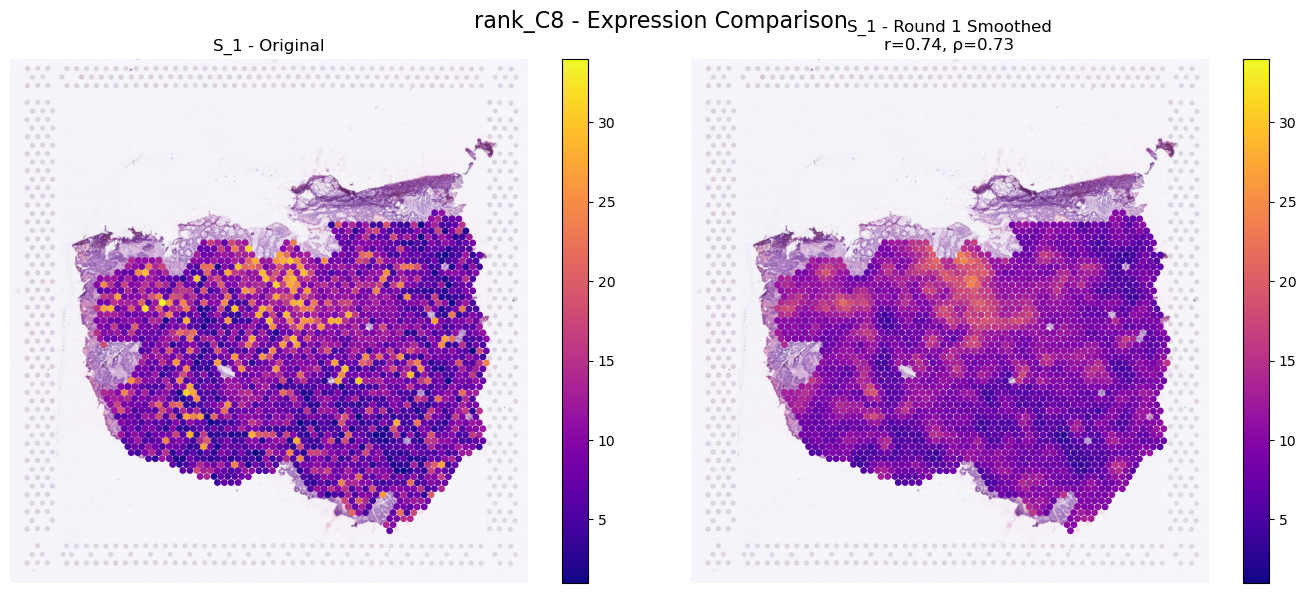

▶️ Round 1 Pearson r = 0.7419, p = 0
▶️ Round 1 Spearman ρ = 0.7252, p = 0

✅ Slide S_1 完成 1 輪 smoothing + 排名 + correlation 分析

====================== 📌 Slide S_2 ======================


🔁 Round 1 smoothing with radius = 40
📊 Slide S_2 - Round 1 - Avg Pearson r = 0.8382, Avg Spearman ρ = 0.7956
🔍 S_2 - rank_C8 - Pearson: 0.7456, Spearman: 0.6507


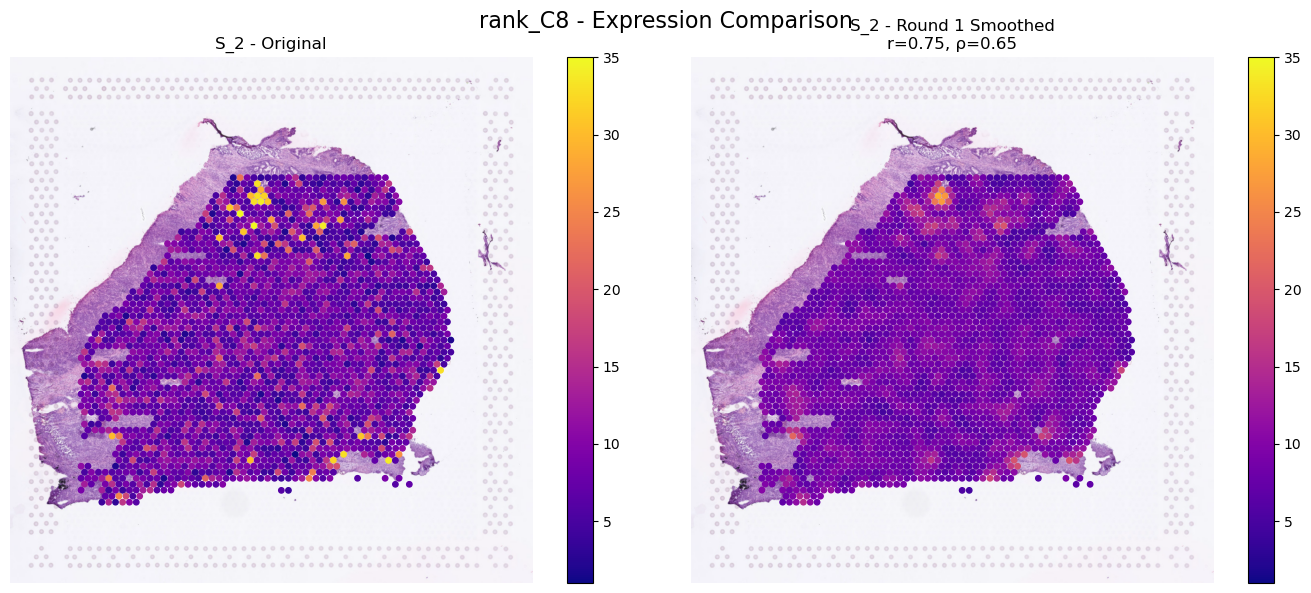

▶️ Round 1 Pearson r = 0.7456, p = 0
▶️ Round 1 Spearman ρ = 0.6507, p = 4.05e-259

✅ Slide S_2 完成 1 輪 smoothing + 排名 + correlation 分析

====================== 📌 Slide S_3 ======================


🔁 Round 1 smoothing with radius = 40
📊 Slide S_3 - Round 1 - Avg Pearson r = 0.7926, Avg Spearman ρ = 0.7650
🔍 S_3 - rank_C8 - Pearson: 0.7032, Spearman: 0.6694


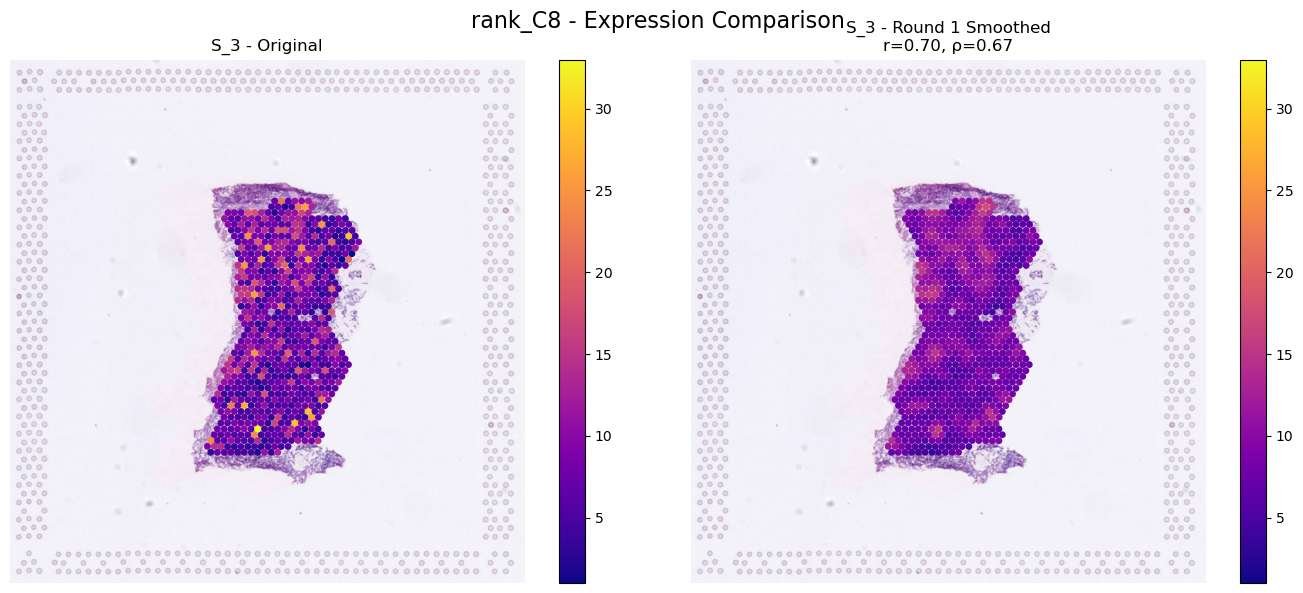

▶️ Round 1 Pearson r = 0.7032, p = 5.229e-104
▶️ Round 1 Spearman ρ = 0.6694, p = 7.038e-91

✅ Slide S_3 完成 1 輪 smoothing + 排名 + correlation 分析

====================== 📌 Slide S_4 ======================


🔁 Round 1 smoothing with radius = 40
📊 Slide S_4 - Round 1 - Avg Pearson r = 0.8724, Avg Spearman ρ = 0.8595
🔍 S_4 - rank_C8 - Pearson: 0.7027, Spearman: 0.6795


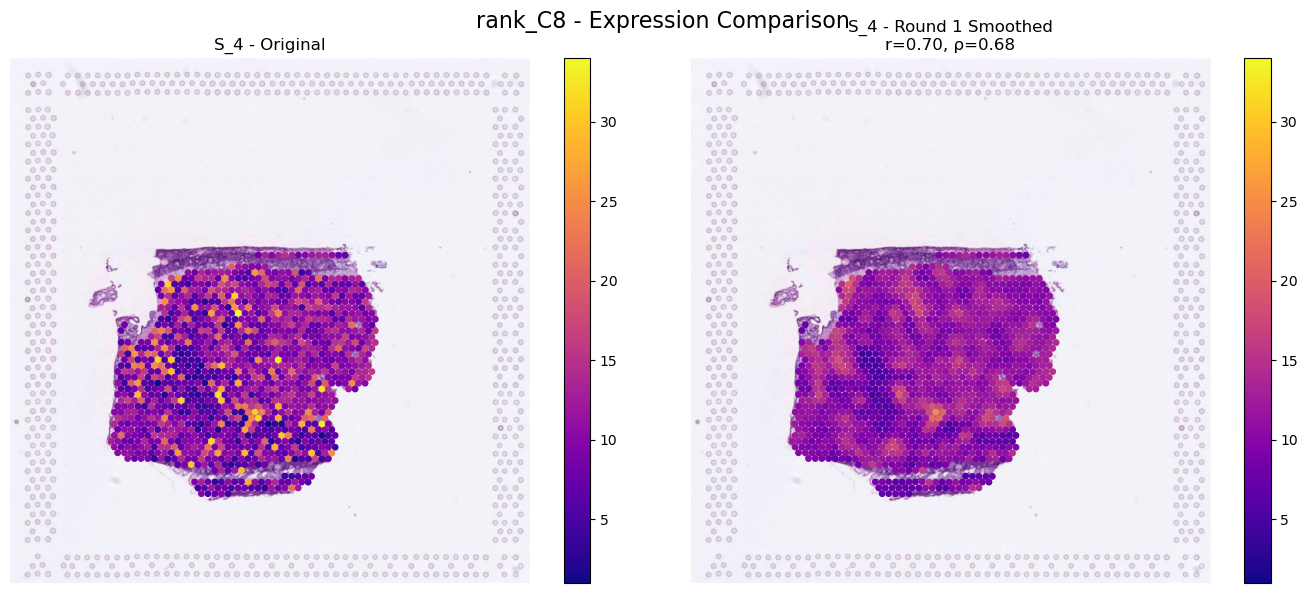

▶️ Round 1 Pearson r = 0.7027, p = 2.01e-177
▶️ Round 1 Spearman ρ = 0.6795, p = 1.494e-161

✅ Slide S_4 完成 1 輪 smoothing + 排名 + correlation 分析

====================== 📌 Slide S_5 ======================


🔁 Round 1 smoothing with radius = 40
📊 Slide S_5 - Round 1 - Avg Pearson r = 0.8547, Avg Spearman ρ = 0.8371
🔍 S_5 - rank_C8 - Pearson: 0.7896, Spearman: 0.8002


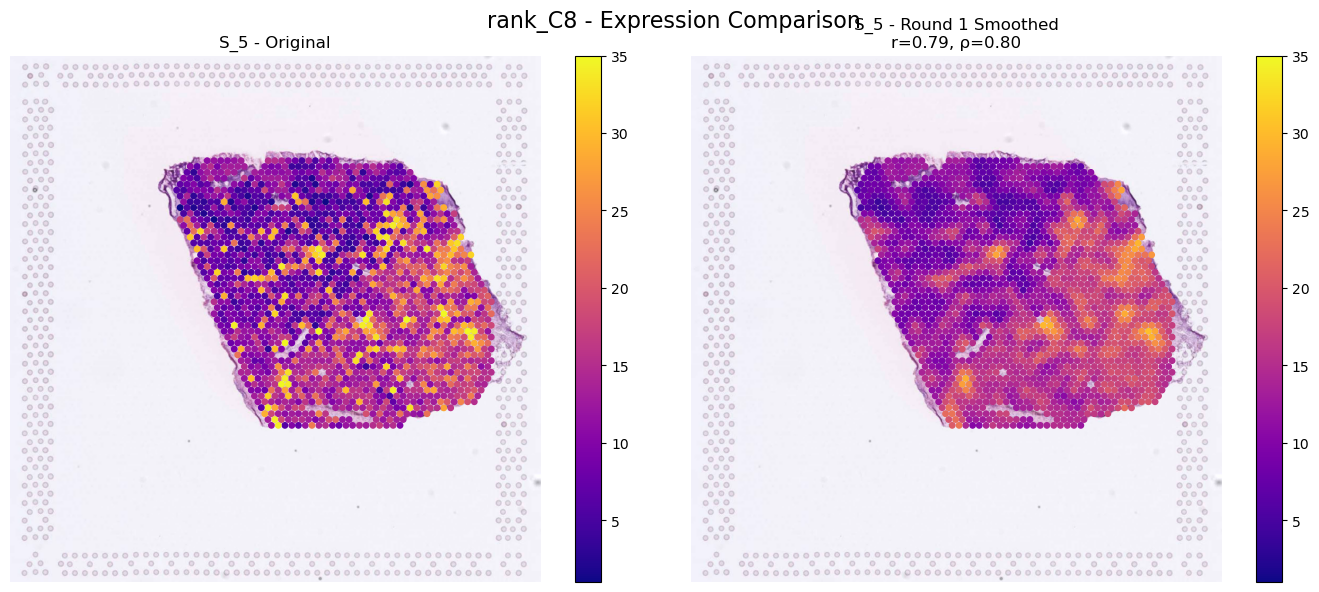

▶️ Round 1 Pearson r = 0.7896, p = 0
▶️ Round 1 Spearman ρ = 0.8002, p = 0

✅ Slide S_5 完成 1 輪 smoothing + 排名 + correlation 分析

====================== 📌 Slide S_6 ======================


🔁 Round 1 smoothing with radius = 40
📊 Slide S_6 - Round 1 - Avg Pearson r = 0.8291, Avg Spearman ρ = 0.8197
🔍 S_6 - rank_C8 - Pearson: 0.7094, Spearman: 0.7001


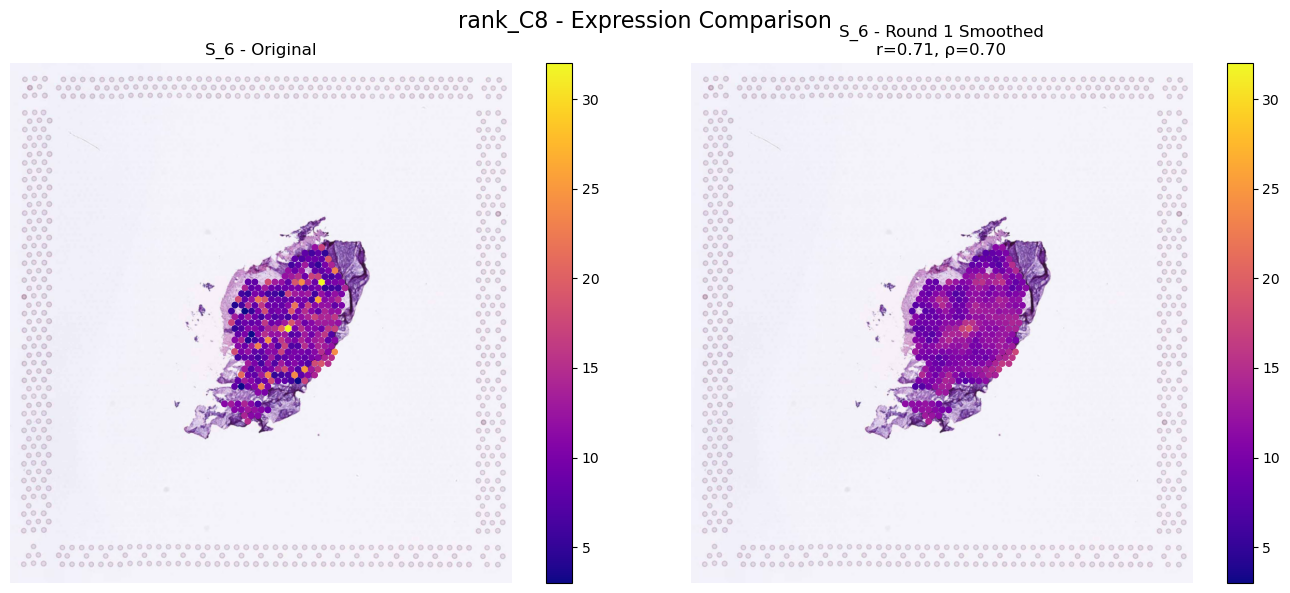

▶️ Round 1 Pearson r = 0.7094, p = 1.827e-51
▶️ Round 1 Spearman ρ = 0.7001, p = 1.322e-49

✅ Slide S_6 完成 1 輪 smoothing + 排名 + correlation 分析

================== 📈 Overall Slide-level Average Correlation ==================

       cell_type_pearson  cell_type_spearman  avg_pearson  avg_spearman
slide                                                                  
S_1               0.7419              0.7252       0.8476        0.8335
S_2               0.7456              0.6507       0.8382        0.7956
S_3               0.7032              0.6694       0.7926        0.7650
S_4               0.7027              0.6795       0.8724        0.8595
S_5               0.7896              0.8002       0.8547        0.8371
S_6               0.7094              0.7001       0.8291        0.8197


slide  round cell_type  cell_type_pearson  cell_type_spearman  avg_pearson  \
0   S_1      1   rank_C8           0.741863            0.725205     0.847585   
1   S_2      1   rank_C8           0.745562            0.650686     0.838156   
2   S_3      1   rank_C8           0.703200            0.669428     0.792586   
3   S_4      1   rank_C8           0.702745            0.679470     0.872394   
4   S_5      1   rank_C8           0.789634            0.800210     0.854674   
5   S_6      1   rank_C8           0.709408            0.700058     0.829127   

   avg_spearman  
0      0.833548  
1      0.795579  
2      0.764980  
3      0.859478  
4      0.837107  
5      0.819723

In [ ]:

process_slide_smoothing_and_ranking(
    spot_h5_path="dataset/spot-rank/version-1/directly_rank_train_spots.h5",
    image_h5_path="./dataset/elucidata_ai_challenge_data.h5",
    slide_id=["S_1", "S_2", "S_3","S_4", "S_5", "S_6"],  # ✅ 傳 list 會依序處理每個 slide
    cell_prefix="rank_C",             # 例如處理 C1~C35
    cell_type_to_plot="rank_C8",     # 但只畫出 C14
    radius=40,
    rounds=1
)


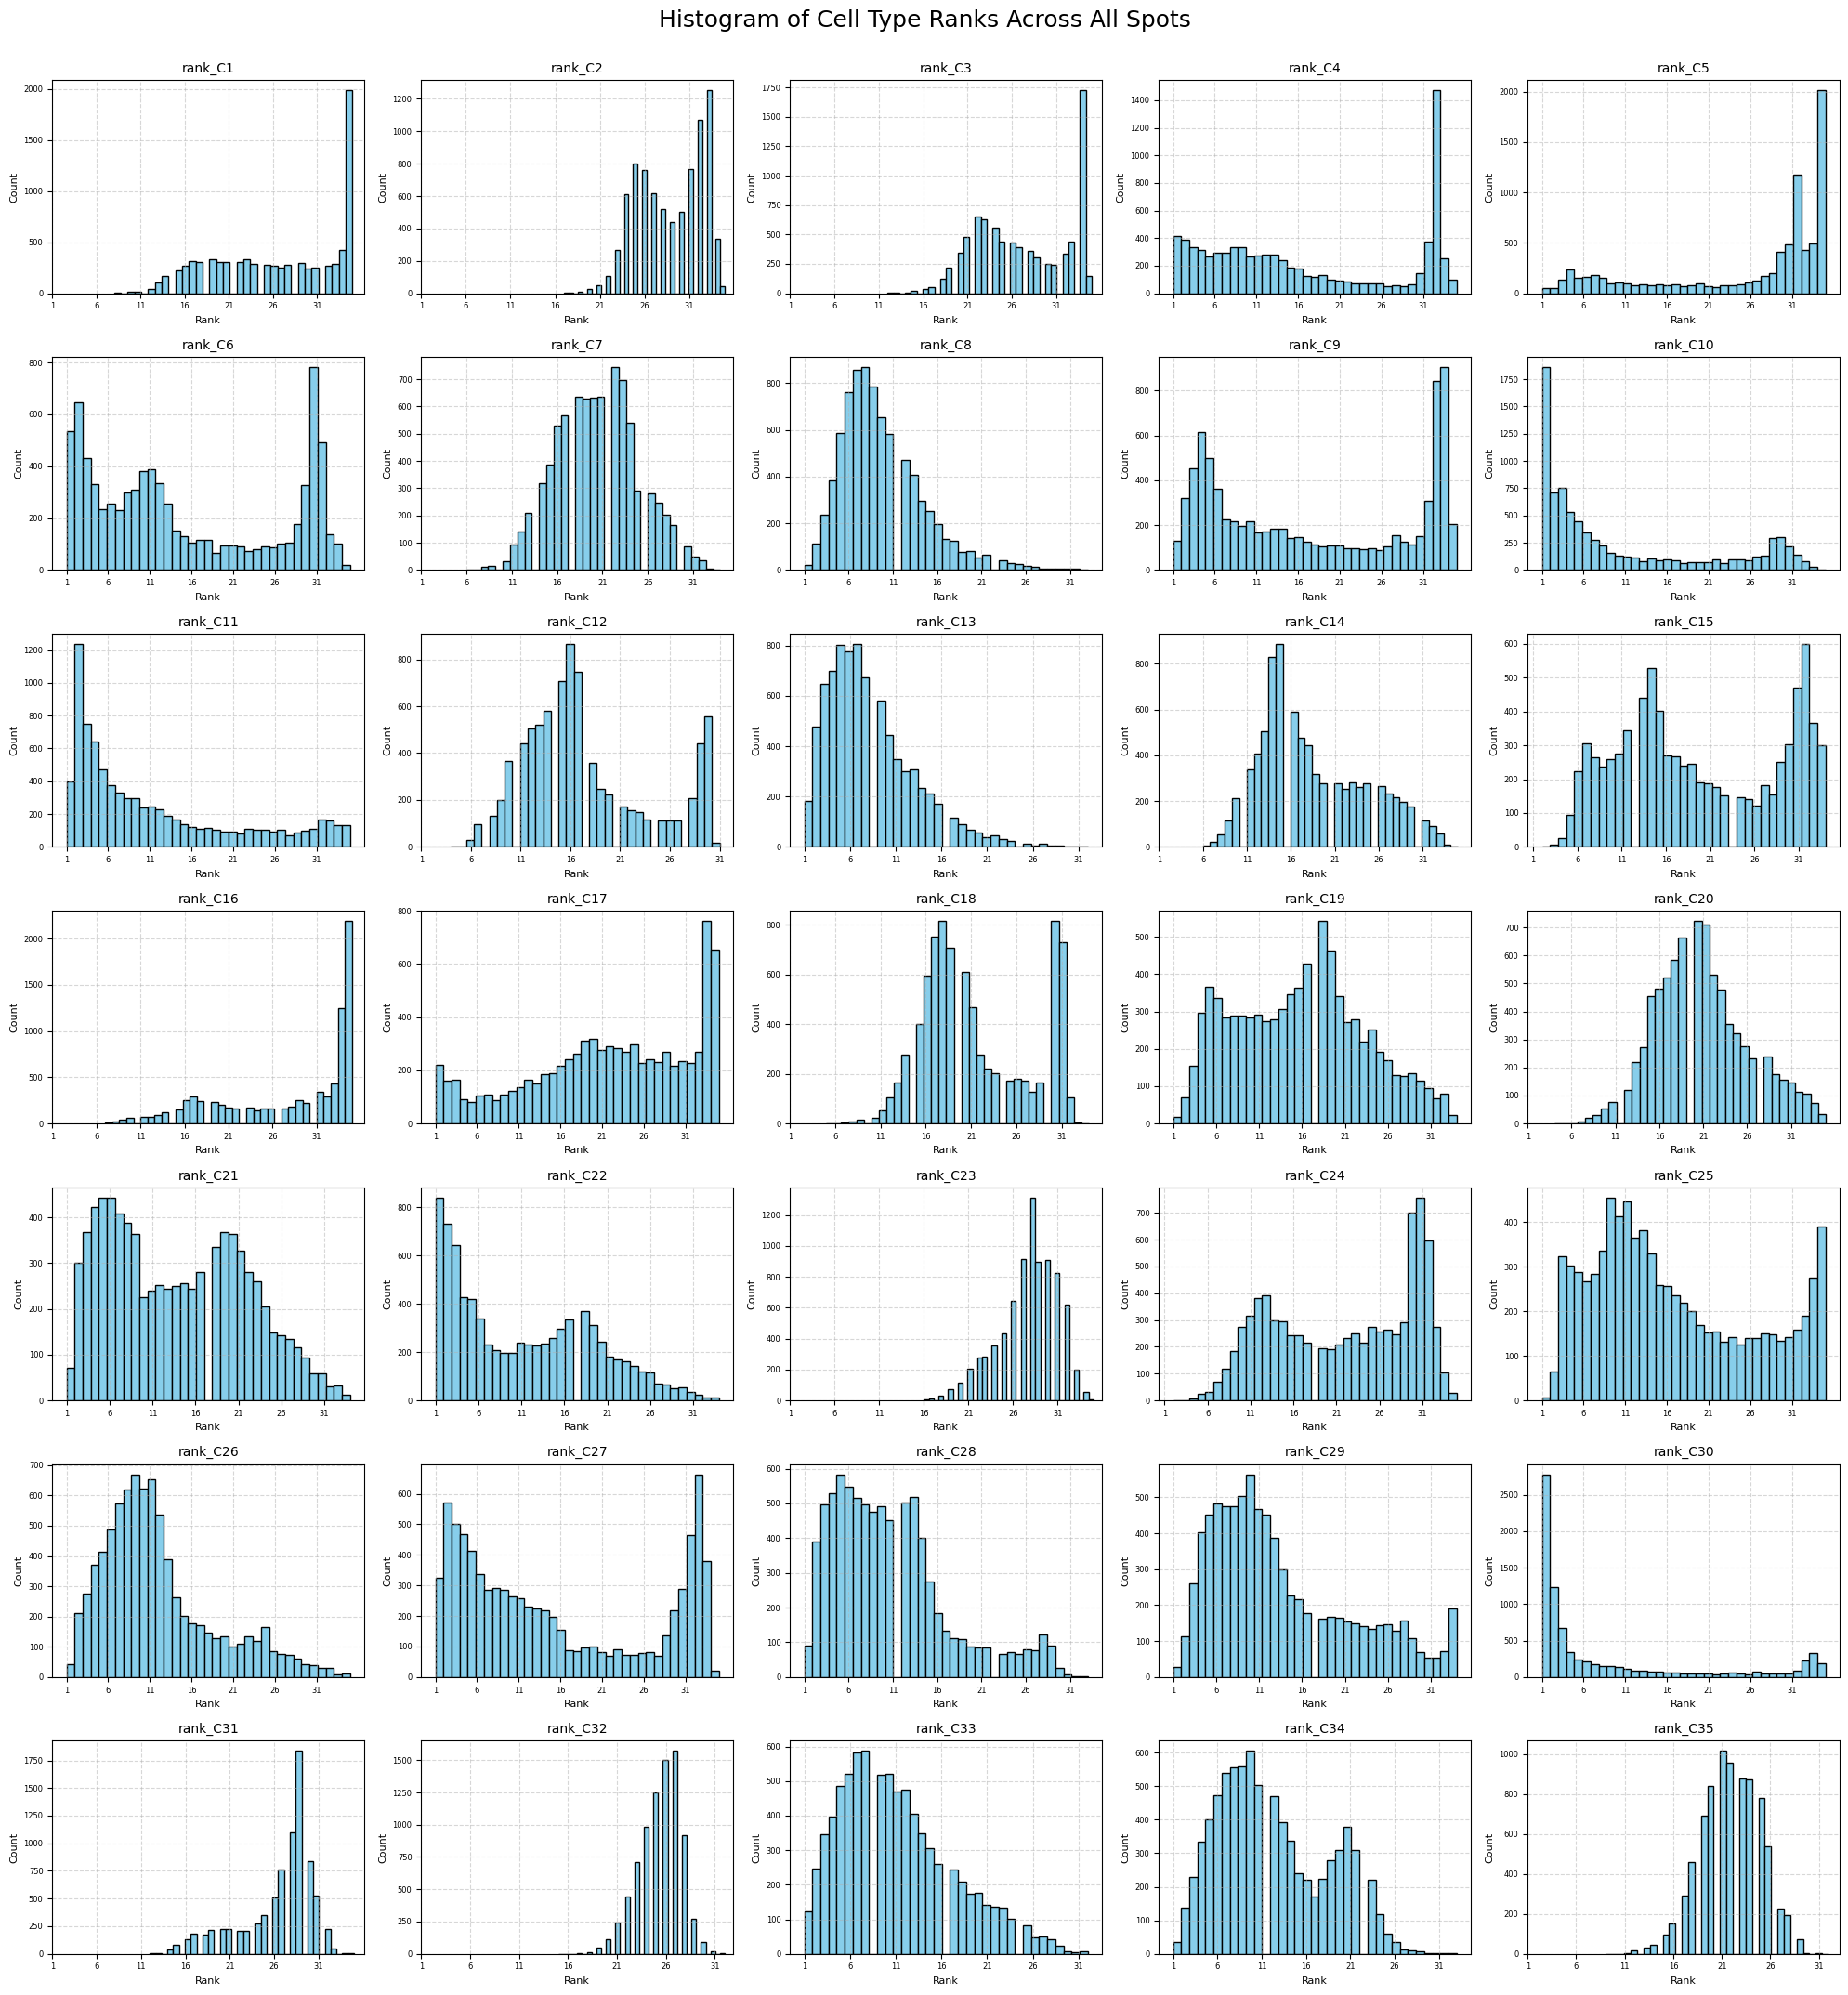

In [78]:
import matplotlib.pyplot as plt
import math

# 所有排名欄位
rank_cols = [col for col in ranked_df.columns if col.startswith("rank_")]
n_plots = len(rank_cols)

# 設定 subplot 的行與列數（例如每列 5 張圖）
n_cols = 5
n_rows = math.ceil(n_plots / n_cols)

# 建立畫布
plt.figure(figsize=(n_cols * 4, n_rows * 3))

for i, col in enumerate(rank_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.hist(ranked_df[col], bins=35, color='skyblue', edgecolor='black')
    plt.title(col, fontsize=10)
    plt.xlabel("Rank", fontsize=8)
    plt.ylabel("Count", fontsize=8)
    plt.xticks(range(1, 36, 5), fontsize=6)
    plt.yticks(fontsize=6)
    plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("Histogram of Cell Type Ranks Across All Spots", fontsize=18, y=1.02)
plt.show()


## Save data

In [83]:
import h5py
import numpy as np
import pandas as pd

# 假設 filtered_df (包含 slide_name, x, y 與所有 zscore_log2_filtered_{cell} 欄位) 
# 與 cell_type_cols 以及 zscore_params 已經存在

# 例如：
# cell_type_cols = ['C1', 'C2', ..., 'C35']
# zscore_params = {"C1": {"mean": ..., "std": ...}, "C2": {"mean": ..., "std": ...}, ...}
# filtered_df 為預處理後的 DataFrame

# 設定輸出 HDF5 檔案路徑
save_folder = "./dataset/spot-rank/version-2/"
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
output_file = os.path.join(save_folder, "gu_rank_radius_30.h5")

with h5py.File(output_file, "w") as f_out:
    # 建立 group "spots/Train"
    slides_group = f_out.create_group("spots/Train")
    
    # 根據 slide_name 分組，並將每個 slide 的資料存入 dataset
    for slide_name, group_df in ranked_df.groupby("slide_name"):
        # 選擇需要儲存的欄位：x, y 以及所有 zscore_log2_filtered_{cell} 欄位

        cols_to_save = ["x", "y"] + [f"{col}" for col in cell_type_cols]
        # 取出對應的資料
        df_to_save = group_df[cols_to_save].copy()
        
        # 將 DataFrame 轉成 numpy 結構化陣列（不保存 index）
        rec_array = df_to_save.to_records(index=False)
        
        # 存入 group，鍵為 slide_name
        slides_group.create_dataset(slide_name, data=rec_array)
        print(f"Slide {slide_name} 資料已存入 HDF5。")
    print(f"Saved{cols_to_save}")

        
print(f"所有資料與參數已存入 HDF5 檔案：{output_file}")


Slide S_1 資料已存入 HDF5。
Slide S_2 資料已存入 HDF5。
Slide S_3 資料已存入 HDF5。
Slide S_4 資料已存入 HDF5。
Slide S_5 資料已存入 HDF5。
Slide S_6 資料已存入 HDF5。
Saved['x', 'y', 'rank_C1', 'rank_C2', 'rank_C3', 'rank_C4', 'rank_C5', 'rank_C6', 'rank_C7', 'rank_C8', 'rank_C9', 'rank_C10', 'rank_C11', 'rank_C12', 'rank_C13', 'rank_C14', 'rank_C15', 'rank_C16', 'rank_C17', 'rank_C18', 'rank_C19', 'rank_C20', 'rank_C21', 'rank_C22', 'rank_C23', 'rank_C24', 'rank_C25', 'rank_C26', 'rank_C27', 'rank_C28', 'rank_C29', 'rank_C30', 'rank_C31', 'rank_C32', 'rank_C33', 'rank_C34', 'rank_C35']
所有資料與參數已存入 HDF5 檔案：./dataset/spot-rank/version-2/gu_rank_radius_30.h5


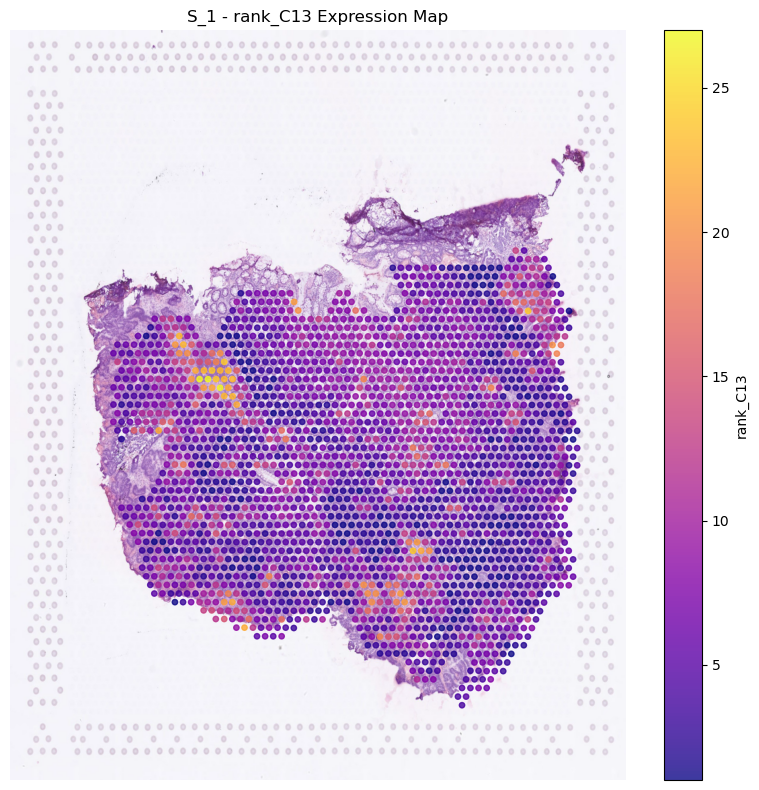

In [84]:
from python_scripts.expression_plot_utils import plot_cell_expression_on_slide
plot_cell_expression_on_slide(
    slide_id = "S_1",
    cell_type = "C13",
    cell_prefix="rank_",  # or zscore_boxcox_filtered_
    image_path="./dataset/elucidata_ai_challenge_data.h5",
    spot_path="dataset/spot-rank/version-2/gu_rank_radius_30.h5",
    group_name="Train"
)